In [1]:
!pip install mplsoccer > /dev/null

In [2]:
import json
from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

In [3]:
with open('../../data/whoscored/data.json', 'r') as file:
    data = json.load(file)

In [4]:
# print all unique events in dataset
# note, except this events, there are also a lot of useful information in "qualifiers"
events = set([event_type['type']['displayName'] for event_type in data['matchCentreData']['events']])
print(events)

{'MissedShots', 'BallTouch', 'Punch', 'Start', 'SubstitutionOn', 'Goal', 'BlockedPass', 'SavedShot', 'FormationSet', 'Challenge', 'OffsideGiven', 'Tackle', 'ShotOnPost', 'Aerial', 'BallRecovery', 'Smother', 'Save', 'Dispossessed', 'OffsideProvoked', 'Card', 'ShieldBallOpp', 'KeeperSweeper', 'Foul', 'KeeperPickup', 'SubstitutionOff', 'CornerAwarded', 'End', 'Claim', 'TakeOn', 'Clearance', 'Interception', 'Pass', 'OffsidePass'}


In [5]:
qualifiers = set([q['type']['displayName'] for event_type in data['matchCentreData']['events'] for q in event_type['qualifiers']])
print(qualifiers)

{'FromCorner', 'HighRight', 'DivingSave', 'RelatedEventId', 'CornerTaken', 'ParriedDanger', 'BoxRight', 'ThrowinSetPiece', 'KeeperThrow', 'HeadPass', 'BigChance', 'BoxLeft', 'CaptainPlayerId', 'LowLeft', 'PassEndY', 'OverRun', 'KeeperSaveInTheBox', 'SixYardBlock', 'GoalMouthY', 'Hands', 'MissHigh', 'TeamFormation', 'RightFoot', 'HighLeft', 'TeamPlayerFormation', 'PassEndX', 'KeeperSaveObox', 'LayOff', 'Offensive', 'ThrowIn', 'MissLeft', 'FreekickTaken', 'InvolvedPlayers', 'BoxCentre', 'MissRight', 'GoalKick', 'BlockedX', 'LastMan', 'OutfielderBlock', 'DeepBoxLeft', 'Chipped', 'Cross', 'GoalMouthZ', 'LowRight', 'ShotAssist', 'IntentionalAssist', 'OutOfBoxCentre', 'LeftFoot', 'BigChanceCreated', 'Angle', 'Blocked', 'StandingSave', 'ParriedSafe', 'HighClaim', 'Foul', 'LowCentre', 'SetPiece', 'OppositeRelatedEvent', 'Zone', 'KeyPass', 'SmallBoxCentre', 'Length', 'Collected', 'DeepBoxRight', 'RegularPlay', 'BlockedCross', 'IndirectFreekickTaken', 'Head', 'FormationSlot', 'Assisted', 'Jersey

In [6]:
player_dict = data['matchCentreData']['playerIdNameDictionary']

In [7]:
def get_team_event_df(data: list):
    result = []
    x = []
    y = []
    players = []
    for event_data in data:
        x.append(event_data['x'])
        y.append(event_data['y'])
        if "playerId" in event_data:
            players.append(player_dict[str(event_data["playerId"])])
        else:
            players += None
    result = pd.DataFrame({"x" : x, "y" : y, "players": players})
    return result

In [8]:
home_team = "Barcelona"
away_team = "Real Madrid"

In [9]:
def legend_without_duplicate_labels(handles, labels):
    # Use Counter to count occurrences of each value in the list and convert to dict
    counts = dict(Counter(labels))
    
    # Sort the counts dictionary based on values in descending order
    counts = {k: [v] for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}

    # Iterate through handles and labels, append handles to counts dictionary
    _ = [counts[l].append(h) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]

    # Create a list of tuples with unique labels and corresponding handles
    unique = [(value[1], key+f": {value[0]}") for key, value in counts.items()]

    # Unzip the list of tuples and return two separate lists
    return zip(*unique)

In [10]:
def draw_scatter_pitch(home_team_events_df, away_team_events_df, event_types="", legend_list=True):
    """
    Draw a scatter plot on a soccer pitch for events of two teams.

    Parameters:
    - home_team_events_df: DataFrame containing events data for the home team.
    - away_team_events_df: DataFrame containing events data for the away team.
    - event_types: String specifying the types of events to be displayed (optional).
    - legend_list: Boolean indicating whether to use a legend with a list of players (True) or a combined legend (False).

    Returns:
    - None
    """
    # Set up the pitch
    pitch = Pitch(pitch_type='opta', pitch_color='#22312b', line_color='#c7d5cc')
    fig, ax = pitch.draw(figsize=(16, 10), constrained_layout=True, tight_layout=False)
    fig.set_facecolor('#22312b')

    # Check if a list legend or a combined legend is requested
    if not legend_list:
        # Scatter plot for home team events
        sc1 = pitch.scatter(home_team_events_df.x, home_team_events_df.y, s=300, c='#db0030', label=home_team, ax=ax)
        # Scatter plot for away team events (substract 100 to correctly display away team)
        sc2 = pitch.scatter(100 - away_team_events_df.x, 100 - away_team_events_df.y, s=300, c='#00659f', label=away_team, ax=ax)
        # Configure the legend
        ax.legend(facecolor='white', fontsize=15, loc='lower center', bbox_to_anchor=(0.5, -0.05),
                  ncol=2, fancybox=True)
    else:
        # Scatter plot for each player in the home team
        for _, row in home_team_events_df.iterrows():
            pitch.scatter(row.x, row.y, s=400, c='#db0030', label=row.players, ax=ax)

        # Get legend handles and labels for the home team
        h, l = ax.get_legend_handles_labels()
        # Configure the home team legend
        plt.rcParams['legend.title_fontsize'] = 20
        legend_home = plt.legend(*legend_without_duplicate_labels(h, l), title=r"$\bf{Barcelona}$", edgecolor='#22312b',
                                 facecolor='#22312b', labelcolor='#edede9', fontsize=15, loc='upper left', bbox_to_anchor=(-0.28, 1))
        legend_home.get_title().set_color('#edede9')

        # Scatter plot for each player in the away team
        for _, row in away_team_events_df.iterrows():
            pitch.scatter(100 - row.x, 100 - row.y, s=400, c='#00659f', label=row.players, ax=ax)

        # Get legend handles and labels for the away team
        h, l = ax.get_legend_handles_labels()
        # Configure the away team legend
        legend_away = plt.legend(*legend_without_duplicate_labels(h[len(home_team_events_df):], l[len(home_team_events_df):]),
                                 title=r"$\bf{Real\ Madrid}$", facecolor='#22312b', labelcolor='#edede9', fontsize=15, loc='upper right',
                                 bbox_to_anchor=(1.28, 1), edgecolor='#22312b',)
        legend_away.get_title().set_color('#edede9')

        # Add both legends to the plot
        ax.add_artist(legend_home)
        ax.add_artist(legend_away)

    # Set the title for the plot
    ax_title = ax.set_title(f'{home_team} vs {away_team} {event_types}\n{len(home_team_events_df)} : {len(away_team_events_df)}',
                            fontsize=20, color='#edede9')


# Draw blocks

## Option 1

In [11]:
def is_qualifier(qualifiers, name):
    for q in qualifiers:
        if q["type"]["displayName"] == name:
            return True
    return False


home_team_events = list(filter(lambda x: (
    ((x['type']['displayName'] in ['Save'] and not (is_qualifier(x['qualifiers'], "KeeperSaveObox") or is_qualifier(x['qualifiers'], "KeeperSaveInTheBox")))
    or (x['type']['displayName'] in ['BlockedPass'] or is_qualifier(x['qualifiers'], "BlockedCross")))
    and x['teamId'] == data['matchCentreData']['home']['teamId']
    and x['outcomeType']['value'] == 1
), data['matchCentreData']['events']))
home_team_events_df = get_team_event_df(home_team_events)

away_team_events = list(filter(lambda x: (
    ((x['type']['displayName'] in ['Save'] and not (is_qualifier(x['qualifiers'], "KeeperSaveObox") or is_qualifier(x['qualifiers'], "KeeperSaveInTheBox")))
    or (x['type']['displayName'] in ['BlockedPass'] or is_qualifier(x['qualifiers'], "BlockedCross")))
    and x['teamId'] == data['matchCentreData']['away']['teamId']
    and x['outcomeType']['value'] == 1
), data['matchCentreData']['events']))
away_team_events_df = get_team_event_df(away_team_events)

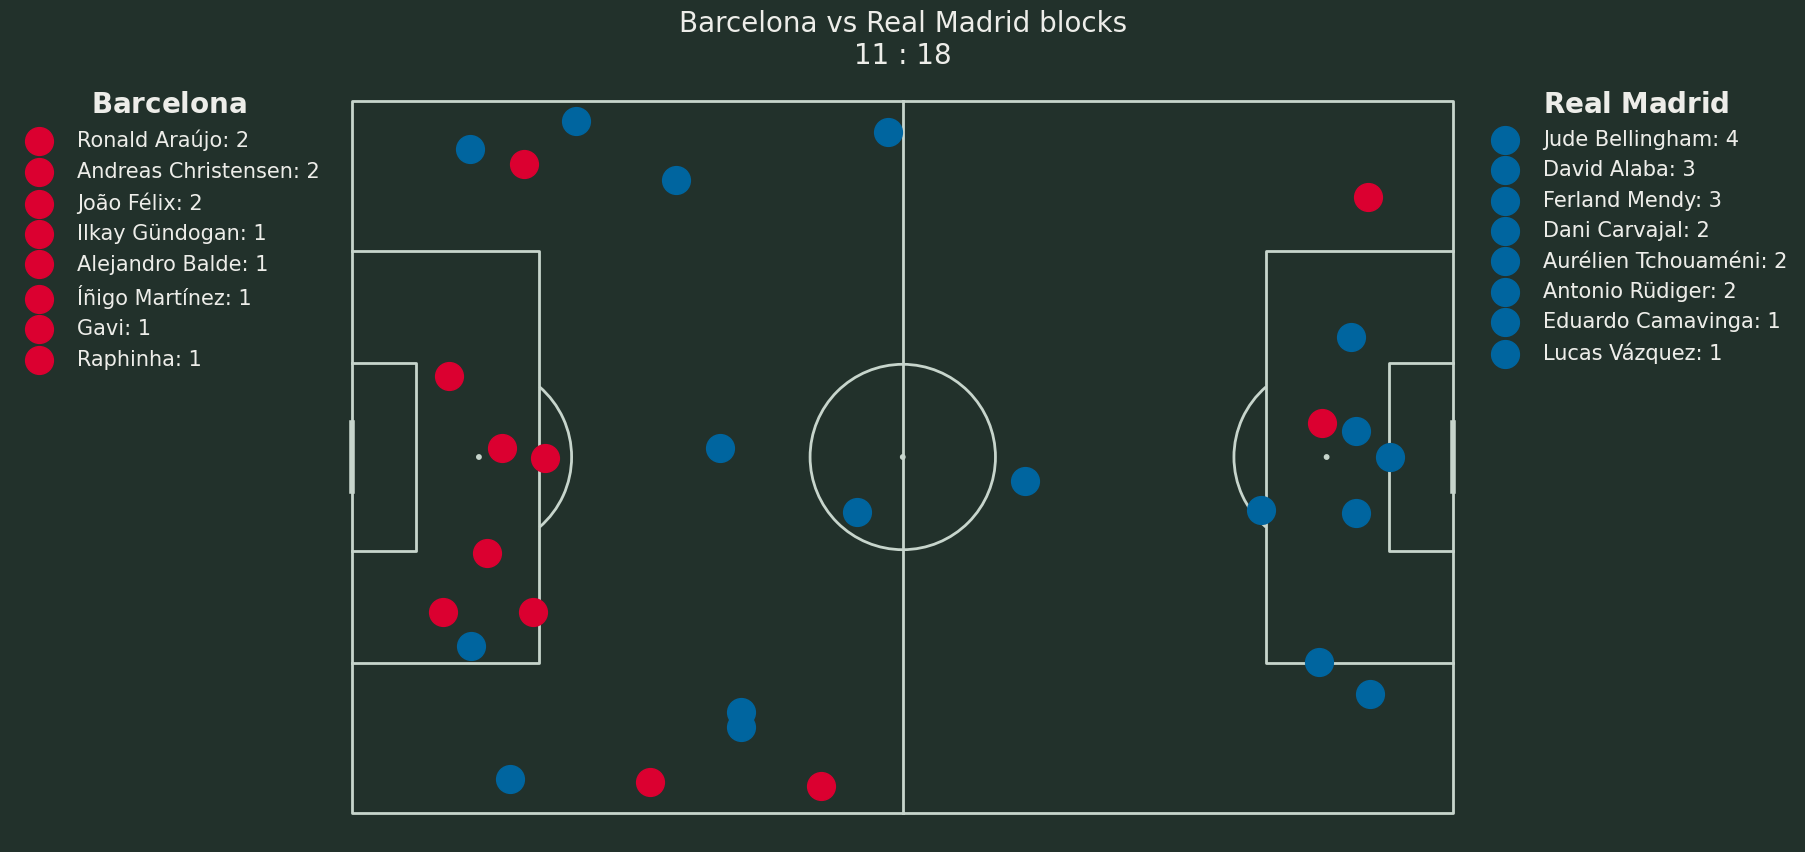

In [12]:
draw_scatter_pitch(home_team_events_df, away_team_events_df, event_types="blocks", legend_list=True)

## Option 2

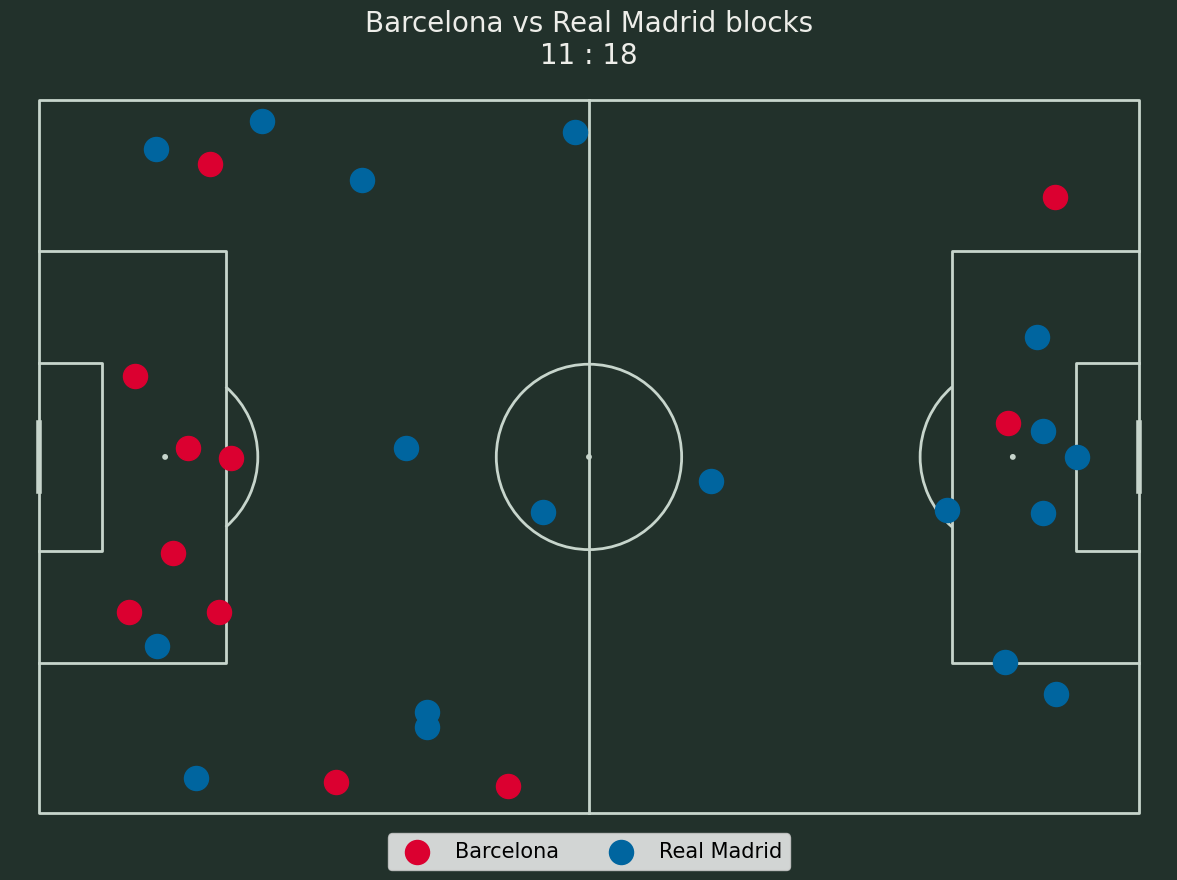

In [13]:
draw_scatter_pitch(home_team_events_df, away_team_events_df, event_types="blocks", legend_list=False)

# Draw aerial duels

draw_scatter_pitch() can be used to draw any other events, for example aerial duels

In [14]:
home_team_events = list(filter(lambda x: (
    x['type']['displayName'] in ['Aerial']
    and x['teamId'] == data['matchCentreData']['home']['teamId']
    and x['outcomeType']['value'] == 1
), data['matchCentreData']['events']))
home_team_events_df = get_team_event_df(home_team_events)

away_team_events = list(filter(lambda x: (
    x['type']['displayName'] in ['Aerial']
    and x['teamId'] == data['matchCentreData']['away']['teamId']
    and x['outcomeType']['value'] == 1
), data['matchCentreData']['events']))
away_team_events_df = get_team_event_df(away_team_events)

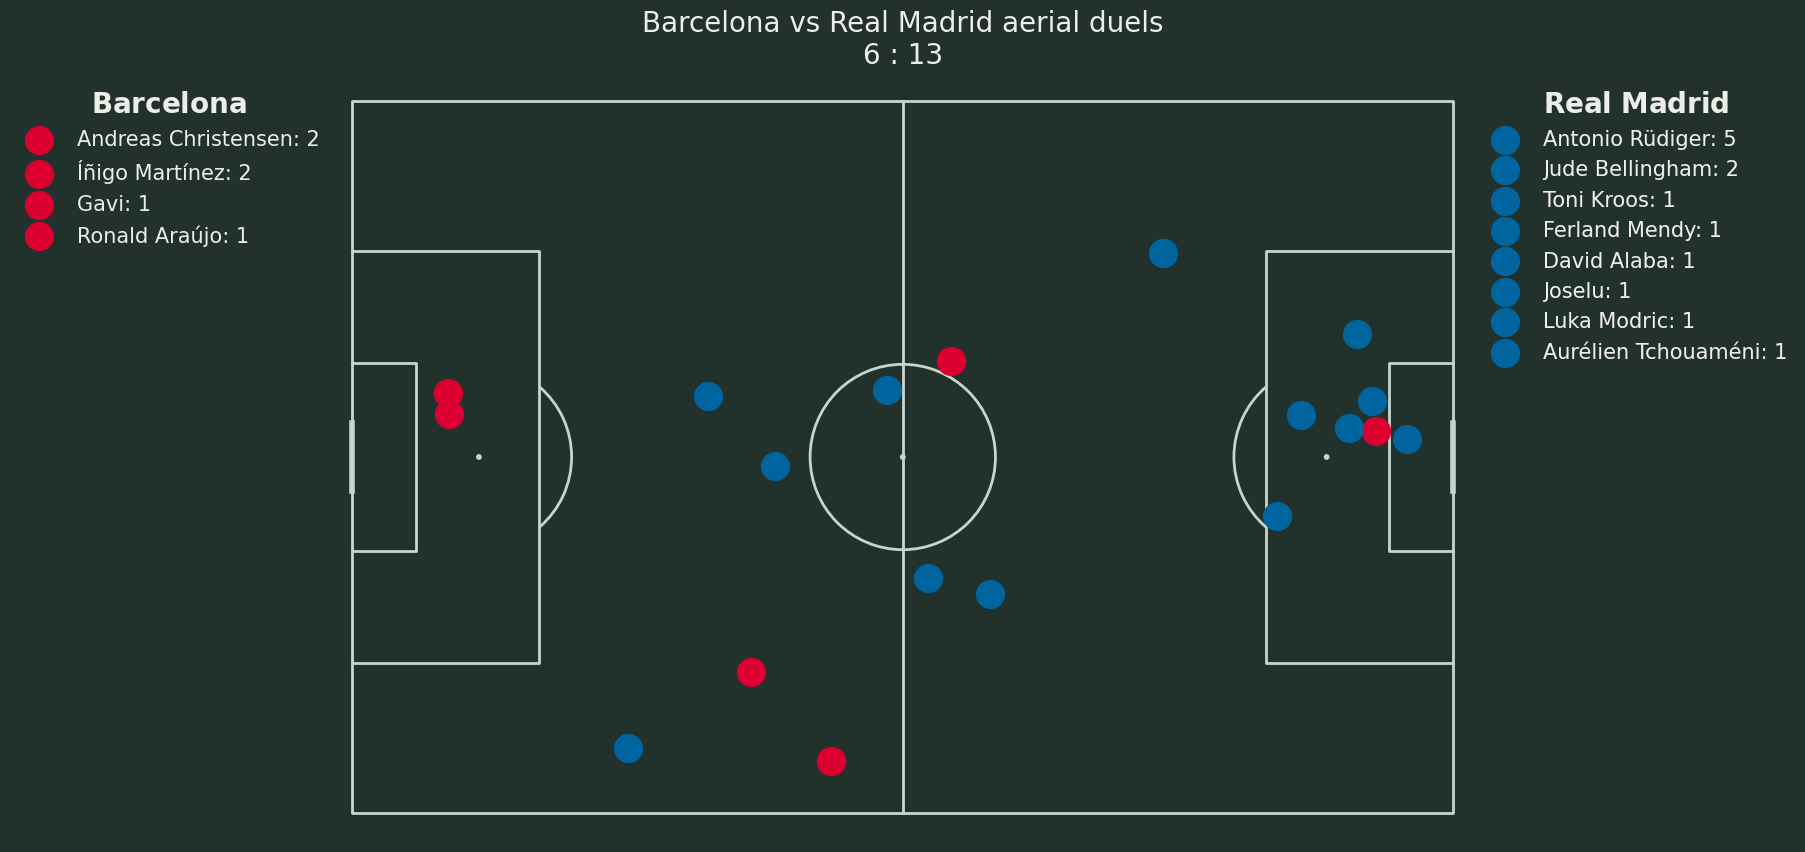

In [15]:
draw_scatter_pitch(home_team_events_df, away_team_events_df, event_types="aerial duels", legend_list=True)